# First Approach Transfer Learning with HLB images employing MobilNet

Accessing to Google Drive

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#pip install split-folders

Libraries to employ in this code

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import os
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline


# !pip install tensorflow
import tensorflow as tf
import keras
from keras.preprocessing import image
from tensorflow.keras.preprocessing import image_dataset_from_directory


#tf.compat.v1.disable_eager_execution()
#from keras.applications.vgg16 import VGG16
#from keras import backend as K
#import tensorflow.keras.backend as K

#from keras.applications.vgg16 import preprocess_input

#from keras.applications.vgg16 import decode_predictions
#K.clear_session()

# Split folders

Is possible to divide the dataset in train, validation and test

Note: seed = 1337 is the default number, is possible to change it

**Just use once**, is recommended to **move the folder to Google Drive** to work more confortable and just use the dataset divided in training and validation images, for this reason, split folders is only employed once and after that, the commands are comented, there's no reason to do it a lot of times

In [5]:
#import splitfolders

# splitfolders.ratio(path,seed=1337, output="Chess-Splitted", ratio=(0.6, 0.2,
# 0.2))

#splitfolders.ratio(ImagesFolder, seed=1337, output="Dataset-Splitted",
#                   ratio=(0.8, 0.2))





Directories that are going to be used and number of elements by class in training and validation

In [6]:
ModelFolder = ('/content/drive/MyDrive/Research/HLB Classification/MobilNet')
ImagesFolder = ('/content/drive/MyDrive/Research/HLB Classification/Database')
ImagesSplittedFolder = ('/content/drive/MyDrive/Research/HLB Classification/Dataset-Splitted')

Training_Folder = ('/content/drive/MyDrive/Research/HLB Classification/Dataset-Splitted/train')
Validation_Folder = ('/content/drive/MyDrive/Research/HLB Classification/Dataset-Splitted/val')

CodeFolder = ('/content')


SubFolders_Training = os.listdir(Training_Folder)
print("Training images by category:")

for iSubFolder in range(len(SubFolders_Training)):
  CurrentFolder = os.path.join(Training_Folder, SubFolders_Training[iSubFolder])
  print(SubFolders_Training[iSubFolder], len(os.listdir(CurrentFolder)))

SubFolders_Validation = os.listdir(Validation_Folder)
print("\nValidation images by category:")

for iSubFolder in range(len(SubFolders_Validation)):
  CurrentFolder = os.path.join(Validation_Folder, SubFolders_Validation[iSubFolder])
  print(SubFolders_Validation[iSubFolder], len(os.listdir(CurrentFolder)))


Training images by category:
1 HLB 349
0 Sanas 273

Validation images by category:
1 HLB 88
0 Sanas 69


Definition of the training and validation datasets with the characteristics of the neural network

In [7]:
Batch_Size = 32
Img_Size = (160, 160)

Train_Dataset = image_dataset_from_directory(Training_Folder,
                                             shuffle = True,
                                             batch_size = Batch_Size,
                                             image_size = Img_Size)

Validation_Dataset_Original = image_dataset_from_directory(Validation_Folder,
                                             shuffle = True,
                                             batch_size = Batch_Size,
                                             image_size = Img_Size)

Found 622 files belonging to 2 classes.
Found 157 files belonging to 2 classes.


Verify the first 9 images and labels of the dataset

In [8]:
sorted(os.listdir(Training_Folder))

['0 Sanas', '1 HLB']

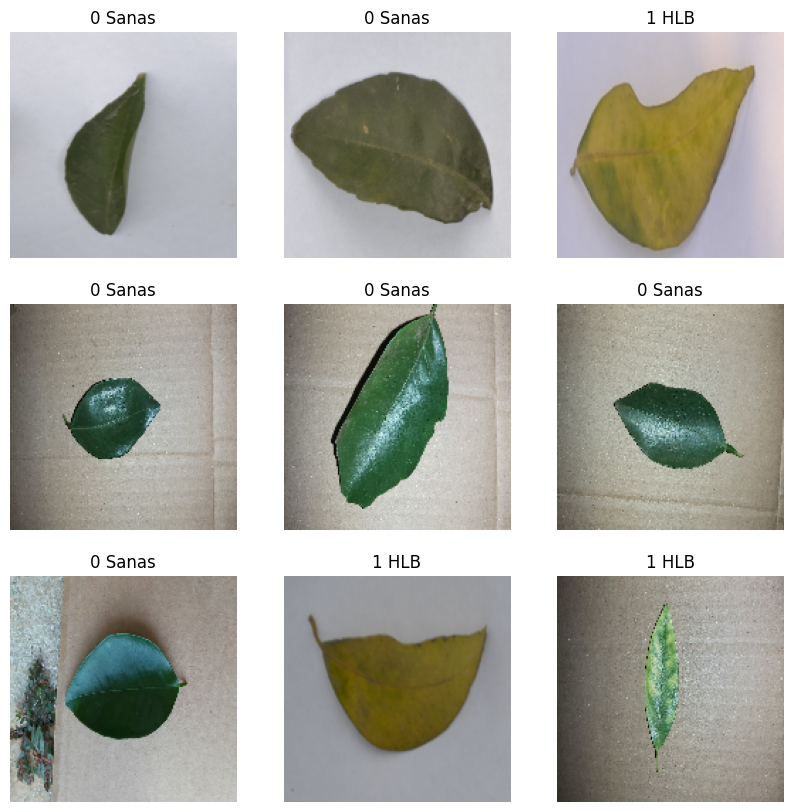

In [9]:
class_names = Train_Dataset.class_names

class_names = Train_Dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in Train_Dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

plt.savefig(os.path.join(ModelFolder, '01 01 Imagenes Prueba.jpg'))


A test dataset is created.

Determine the validation dataset employing a lot of data batches *tf.data.experimental.cardinality*



In [10]:
val_batches = tf.data.experimental.cardinality(Validation_Dataset_Original)
test_dataset = Validation_Dataset_Original.take(val_batches // 5)
Validation_Dataset = Validation_Dataset_Original.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(Validation_Dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))


Number of validation batches: 4
Number of test batches: 1


In [11]:
Autotune = tf.data.AUTOTUNE

Train_Dataset = Train_Dataset.prefetch(buffer_size=Autotune)
Validation_Dataset = Validation_Dataset.prefetch(buffer_size=Autotune)
test_dataset = test_dataset.prefetch(buffer_size=Autotune)

Data augmented

In [12]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomBrightness(factor=0.2),
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation([0, 0.99]),
  tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
  tf.keras.layers.RandomZoom(height_factor = [-0.4, 0.4], width_factor=[-0.4, 0.4])])

Showing the augmented data

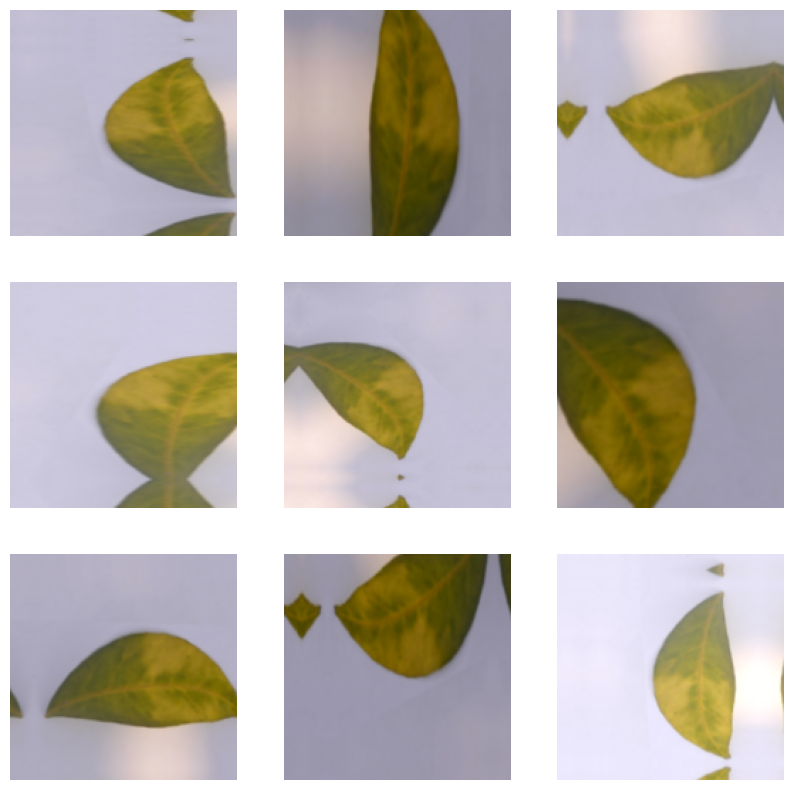

In [13]:
for image, _ in Train_Dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

plt.savefig(os.path.join(ModelFolder, '01 02 Augmented Images.jpg'))

Changing the scale of the pixels values to use **MobilNetV2**

They should be between [-1 and 1], at this momment, they are between [0, 255]


In [14]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

The *bottle neeck layer* is employed to preserve the characteristics with more generalities in comparition with the final layer of the MobilNet model.

The model is employed with the weights trained in ImageNet, when *include_top = false* as argument, the classification layers are not chaarged in the model

In [15]:
# Create the base model from the pre-trained model MobileNet V2
Img_Shape = Img_Size + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape = Img_Shape,
                                               include_top = False,
                                               weights = 'imagenet')

image_batch, label_batch = next(iter(Train_Dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


9406464/9406464 [==============================] - 2s 0us/step
(32, 5, 5, 1280)


Feature extraction

Convolutional base created is frozen and used as a feature extractor. A classification is added at the top and trains the classificatior at the superior level (last layers).

Frozen of the convolutional base is realized with *layer.trainable = False* avoiding that the weights of a specific layer get refreshed during the training.


In [16]:
base_model.trainable = False


**Special note about *BatchNormalization* layers**

A lot of models contains *tf.keras.layers.BatchNormalization*, this is  special case and special warnings should be takenat fine tuning.

When *layer.trainable = False* is employed, BatchNormalization layers is going to execute as inference mode and is not going to refresh the average and variance statistics.

When a model with BatchNormalization layers is unfrozen to make a fine tuning, it should keep the BatchNormalization layers in inference employing *training = False* when is called the base model.

If this is not realized, the refresh applied to non trainable weights will destroy the learned by the model.

In [17]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

**Add a clasification header**


In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a *tf.keras.layers.Dense*  to convert characteristics in one single prediction per image.
An activation layer is not necessary here because this prediction will be treated as a logit or a prime prediction.

**Positive numbers predict the class 1, while negative numbers precict the class 0.**

In [19]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Build the chain model with the data augmented, scale change, *base_model* layers and extracting the characteristics employing the functional API Keras.

As previosly where mentioned, use *training = False* because our model has a BarchNormalization layer.

In [20]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

**Compile the model**

Compile the model before trained. A binary lost cross entropy is employed with *from_logits = True* because we have two clases and a lineal output.

In [21]:
base_learning_rate = 0.0001
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
#model.compile(keras.optimizers.SGD(), loss='mse') # CHECK IF LOSS 'mse' IS AN OPTION
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

In [22]:
len(model.trainable_variables)

2

**Training the model**

In [23]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(Validation_Dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

history = model.fit(Train_Dataset,
                    epochs=initial_epochs,
                    callbacks=[callback],
                    validation_data=Validation_Dataset)



4/4 [==============================] - 76s 333ms/step - loss: 0.9737 - accuracy: 0.5360
initial loss: 0.97
initial accuracy: 0.54
Epoch 1/10
20/20 [==============================] - 102s 4s/step - loss: 0.7555 - accuracy: 0.5193 - val_loss: 0.5616 - val_accuracy: 0.6480
Epoch 2/10
20/20 [==============================] - 30s 973ms/step - loss: 0.5448 - accuracy: 0.7090 - val_loss: 0.4587 - val_accuracy: 0.7920
Epoch 3/10
20/20 [==============================] - 32s 1s/step - loss: 0.4600 - accuracy: 0.7685 - val_loss: 0.4526 - val_accuracy: 0.7440
Epoch 4/10
20/20 [==============================] - 29s 963ms/step - loss: 0.4103 - accuracy: 0.7974 - val_loss: 0.3844 - val_accuracy: 0.7760
Epoch 5/10
20/20 [==============================] - 29s 928ms/step - loss: 0.3688 - accuracy: 0.8392 - val_loss: 0.4022 - val_accuracy: 0.7520
Epoch 6/10
20/20 [==============================] - 30s 985ms/step - loss: 0.3621 - accuracy: 0.8312 - val_loss: 0.3344 - val_accuracy: 0.8320
Epoch 7/10
20/20 

**Learning Curves**

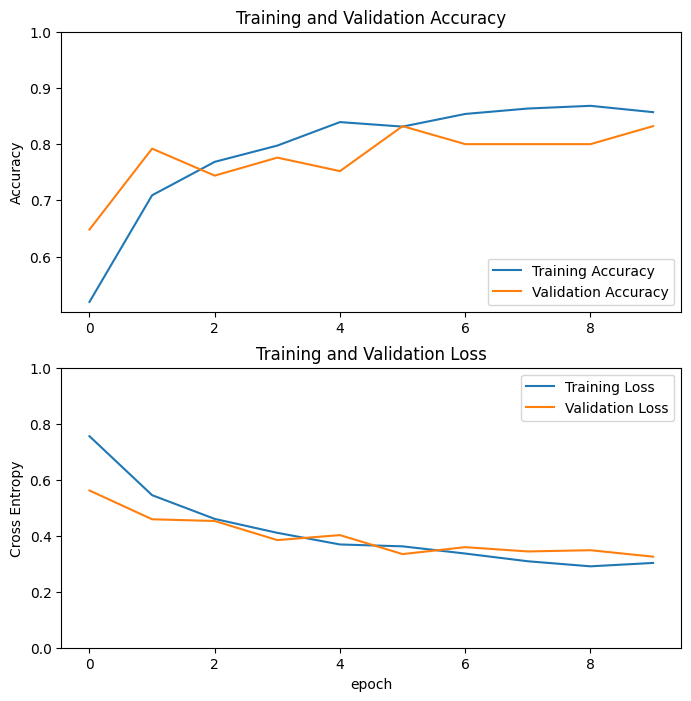

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
#plt.savefig(os.path.join(ModelFolder, '01 03 Training and Validation Accuracy.jpg'))


plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig(os.path.join(ModelFolder, '01 03 Learning Curves.jpg'))
plt.show()


# Fine Tuning

We are going to tune:

*   Learning rate
*   No. of epochs

We are going to unfreeze top layers of the model



In [25]:
# Setting the top layers as trainable
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

# This step improves the accuracy of the model by a few steps
#model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
#              metrics=['accuracy'])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])

#model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
#              loss=keras.losses.BinaryCrossentropy(from_logits=True),
#              metrics=[keras.metrics.BinaryAccuracy()])

Number of layers in the base model:  154


Compile the model

In [26]:
model.summary()

len(model.trainable_variables)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

56

Continue with the training model

In [27]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(Train_Dataset,
                         epochs=total_epochs,
                         callbacks=[callback],
                         initial_epoch=history.epoch[-1],
                         validation_data=Validation_Dataset)


acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


Epoch 10/20
20/20 [==============================] - 47s 977ms/step - loss: 0.2783 - accuracy: 0.8698 - val_loss: 0.4258 - val_accuracy: 0.7840
Epoch 11/20
20/20 [==============================] - 30s 987ms/step - loss: 0.2241 - accuracy: 0.9084 - val_loss: 0.2934 - val_accuracy: 0.8160
Epoch 12/20
20/20 [==============================] - 29s 950ms/step - loss: 0.2170 - accuracy: 0.9260 - val_loss: 0.2448 - val_accuracy: 0.8480
Epoch 13/20
20/20 [==============================] - 29s 967ms/step - loss: 0.2261 - accuracy: 0.9116 - val_loss: 0.1746 - val_accuracy: 0.9120
Epoch 14/20
20/20 [==============================] - 33s 982ms/step - loss: 0.1877 - accuracy: 0.9309 - val_loss: 0.1984 - val_accuracy: 0.8960
Epoch 15/20
20/20 [==============================] - 29s 943ms/step - loss: 0.2066 - accuracy: 0.9164 - val_loss: 0.2010 - val_accuracy: 0.8960
Epoch 16/20
20/20 [==============================] - 29s 972ms/step - loss: 0.1858 - accuracy: 0.9212 - val_loss: 0.1821 - val_accuracy:

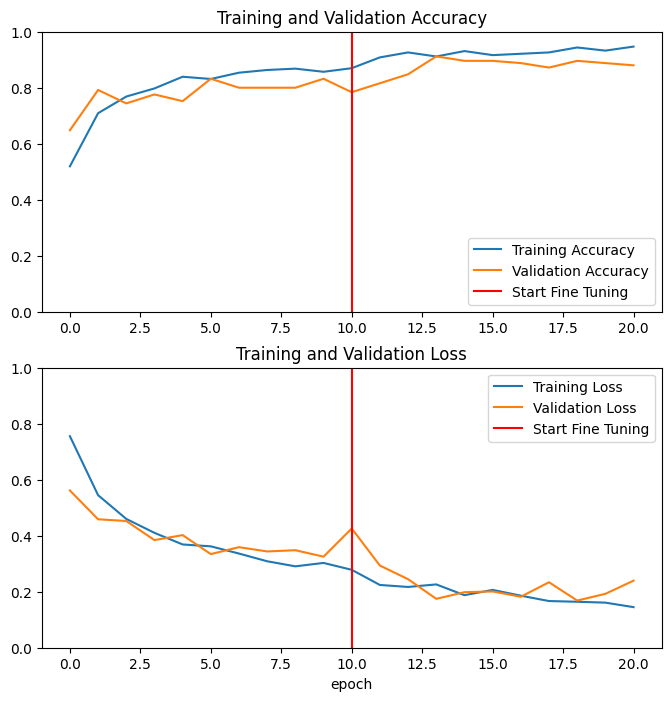

In [28]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.0, 1])
plt.plot([initial_epochs,initial_epochs],
         plt.ylim(),  color = 'red',
         label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs,initial_epochs],
         plt.ylim(), color = 'red',
         label='Start Fine Tuning') # CHANGE COLOR TO RED OR SOMETHING
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.savefig(os.path.join(ModelFolder, '01 04 Learning Curves Fine Tuning.jpg'))
plt.show()

# DESDE AQUÍ: MODIFICAR

Evaluation and prediction

In [29]:
loss, accuracy = model.evaluate(Validation_Dataset)
print('Test accuracy :', accuracy)

4/4 [==============================] - 5s 261ms/step - loss: 0.2336 - accuracy: 0.8800
Test accuracy : 0.8799999952316284


In [30]:
Hola = model.predict(Validation_Dataset).flatten()

4/4 [==============================] - 7s 27ms/step


In [31]:
Hola2 = list(Validation_Dataset)
print(Hola2)

Hola3 = tf.data.Dataset.from_tensor_slices(Validation_Dataset)

[(<tf.Tensor: shape=(32, 160, 160, 3), dtype=float32, numpy=
array([[[[108.625   , 116.      , 120.875   ],
         [ 91.5     , 101.5     , 103.      ],
         [ 84.      ,  95.      , 100.      ],
         ...,
         [ 97.75    ,  94.75    ,  85.75    ],
         [106.75    , 103.75    ,  94.75    ],
         [120.25    , 117.25    , 108.25    ]],

        [[ 98.125   , 105.5     , 110.375   ],
         [ 92.5     , 102.5     , 104.      ],
         [ 92.25    , 103.25    , 108.25    ],
         ...,
         [ 87.      ,  84.      ,  78.      ],
         [100.875   ,  97.875   ,  91.875   ],
         [103.375   , 100.375   ,  94.375   ]],

        [[ 79.25    ,  89.75    ,  97.25    ],
         [ 78.75    ,  89.25    ,  96.75    ],
         [ 69.5     ,  80.      ,  87.5     ],
         ...,
         [111.      , 106.      , 100.      ],
         [102.5     ,  99.5     ,  92.5     ],
         [ 92.5     ,  89.875   ,  82.75    ]],

        ...,

        [[123.5     , 108.5    

ValueError: Slicing dataset elements is not supported for rank 0.

In [ ]:
print(Hola)
prediction = tf.nn.sigmoid(Hola)
prediction = tf.where(prediction < 0.5, 0, 1)

print('Predictions:\n', prediction.numpy())
print('Labels:\n', label_batch)

In [ ]:
#predictions = model.predict_on_batch(image_batch).flatten()
image_batch, label_batch = Validation_Dataset.as_numpy_iterator().next()
prediction = model.predict(Validation_Dataset).flatten()
print(prediction)

prediction = tf.nn.sigmoid(prediction)
prediction = tf.where(prediction < 0.5, 0, 1)

print('Predictions:\n', prediction.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[prediction[i]])
  plt.axis("off")


# Predict if the leaf has HLB or not



In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_mat_val = metrics.confusion_matrix(label_validation, predictions_val)

print(conf_mat_val)

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = Validation_Dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_mat_val = metrics.confusion_matrix(label_validation, predictions_val)

print(conf_mat_val)

In [ ]:
len(Validation_Dataset)

In [ ]:
#list(Validation_Dataset.as_numpy_iterator())[0][1]
list(Validation_Dataset.as_numpy_iterator())[0][1]

In [ ]:
#conf_mat = confusion_matrix(label_batch, predictions)
#print(conf_mat)

#Retrieve a batch of images from the validation set
#image_validation, label_validation = next(iter(Validation_Dataset))

#image_validation, label_validation = Validation_Dataset_Original.as_numpy_iterator().next()

image_validation, label_validation = next(iter(Validation_Dataset))
predictions_val = model.predict(image_validation).flatten()

# Apply a sigmoid since our model returns logits
predictions_val = tf.nn.sigmoid(predictions_val)
predictions_val = tf.where(predictions_val < 0.5, 0, 1)

print('Predictions:\n', predictions_val.numpy())
print('Labels:\n', label_validation)

from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_mat_val = metrics.confusion_matrix(label_validation, predictions_val)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,
                                            display_labels = [0, 1])
ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)

cm_display.plot()
plt.show()
print(conf_mat_val)

#plt.figure(figsize=(10, 10))
#for i in range(9):
#  ax = plt.subplot(3, 3, i + 1)
#  plt.imshow(image_batch[i].astype("uint8"))
#  plt.title(class_names[predictions[i]])
#  plt.axis("off")

# Saving the model

The model ALWAYS has to end with .keras extension

In [ ]:
model.save(ModelFolder + 'MobilNet.keras')  # The file needs to end with the .keras extension

Loading the model

In [ ]:
#model = keras.models.load_model(ModelFolder + 'MobilNet.keras')

# AQUÍ ME QUEDÉ, LISTO PARA CONTINUAR EN ENTRENAMIENTO

https://keras.io/api/data_loading/image/

https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a